[Contrastive] Epoch 1/10, loss=0.5263
[Contrastive] Epoch 2/10, loss=1.0136
[Contrastive] Epoch 3/10, loss=0.4535
[Contrastive] Epoch 4/10, loss=0.2025
[Contrastive] Epoch 5/10, loss=0.1556
[Contrastive] Epoch 6/10, loss=0.1133
[Contrastive] Epoch 7/10, loss=0.7831
[Contrastive] Epoch 8/10, loss=0.1652
[Contrastive] Epoch 9/10, loss=0.2664
[Contrastive] Epoch 10/10, loss=0.1738
跳过元学习：没有有标签数据。


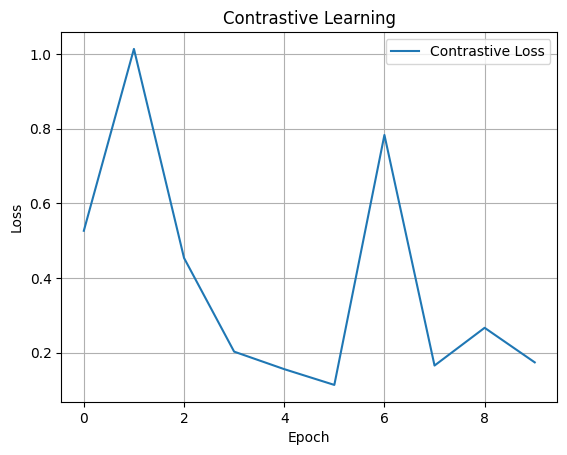

INFO:tensorflow:Assets written to: /tmp/tmpuv1f0a1p/assets


INFO:tensorflow:Assets written to: /tmp/tmpuv1f0a1p/assets
2025-08-18 12:56:04.861403: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-18 12:56:04.861461: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-18 12:56:04.861653: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuv1f0a1p
2025-08-18 12:56:04.868894: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-18 12:56:04.868918: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpuv1f0a1p
2025-08-18 12:56:04.893127: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-18 12:56:04.952420: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpuv1f0a1p
2025-08-18 12:56:05.002065: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

Saved TFLite: lstm_encoder_contrastive.tflite


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import random
import matplotlib.pyplot as plt

# =============================
# 超参数
# =============================
DATA_GLOB = "./data/*.csv"
SEQ_LEN = 64
FEATURE_DIM = 64
BATCH_SIZE = 32
EPOCHS_CONTRASTIVE = 10
EPOCHS_META = 20
INNER_LR = 1e-2
META_LR = 1e-3
NUM_CLASSES = 3
NUM_TASKS = 5
SUPPORT_SIZE = 10
QUERY_SIZE = 20
REPLAY_CAPACITY = 1000
REPLAY_WEIGHT = 0.3
LAMBDA_EWC = 1e-3
FLOWERING_WEIGHT = 2.0  # 花期梯度放大倍數

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# =============================
# 1) 加载 CSV -> 滑窗样本
# =============================
X_labeled_list, y_labeled_list = [], []
X_unlabeled_list = []

for file in sorted(glob.glob(DATA_GLOB)):
    df = pd.read_csv(file).fillna(-1)
    data = df.values.astype(np.float32)
    feats, labels = data[:, :-1], data[:, -1]
    for i in range(len(data) - SEQ_LEN + 1):
        w_x = feats[i:i + SEQ_LEN]
        w_y = labels[i + SEQ_LEN - 1]
        if w_y == -1:
            X_unlabeled_list.append(w_x)
        else:
            X_labeled_list.append(w_x)
            y_labeled_list.append(int(w_y))

X_unlabeled = np.array(X_unlabeled_list, dtype=np.float32) if len(X_unlabeled_list) > 0 else np.empty((0,), dtype=np.float32)
if len(X_labeled_list) > 0:
    X_labeled = np.array(X_labeled_list, dtype=np.float32)
    y_labeled = np.array(y_labeled_list, dtype=np.int32)
else:
    X_labeled = np.empty((0, SEQ_LEN, X_unlabeled.shape[2] if X_unlabeled.size > 0 else 3), dtype=np.float32)
    y_labeled = np.empty((0,), dtype=np.int32)

NUM_FEATS = X_labeled.shape[2] if X_labeled.size > 0 else (X_unlabeled.shape[2] if X_unlabeled.size > 0 else 3)

# =============================
# 2) 对比学习
# =============================
def augment_window(x):
    return x + np.random.normal(0, 0.01, x.shape).astype(np.float32)

def make_contrastive_pairs(X):
    anchors, positives = [], []
    for w in X:
        anchors.append(w)
        positives.append(augment_window(w))
    return np.stack(anchors).astype(np.float32), np.stack(positives).astype(np.float32)

class NTXentLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
    def call(self, z_i, z_j):
        z_i = tf.math.l2_normalize(z_i, axis=1)
        z_j = tf.math.l2_normalize(z_j, axis=1)
        logits = tf.matmul(z_i, z_j, transpose_b=True) / self.temperature
        labels = tf.range(tf.shape(z_i)[0])
        loss_i = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_j = tf.keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(logits), from_logits=True)
        return tf.reduce_mean(loss_i + loss_j)
# =============================
# 2) LSTM Encoder (unroll=True)
# =============================
def build_lstm_encoder(seq_len, num_feats, feature_dim=FEATURE_DIM):
    inp = layers.Input(shape=(seq_len, num_feats))
    # 關鍵：unroll=True，避免 TensorList
    x = layers.LSTM(feature_dim, unroll=True)(inp)
    out = layers.Dense(feature_dim, activation="relu")(x)
    return models.Model(inp, out, name="lstm_encoder")

# =============================
# 3) Meta Model (使用 Encoder)
# =============================
def build_meta_model(encoder, num_classes=NUM_CLASSES):
    inp = layers.Input(shape=(SEQ_LEN, NUM_FEATS))
    x = encoder(inp)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="meta_lstm_classifier")
 
lstm_encoder = build_lstm_encoder(SEQ_LEN, NUM_FEATS, FEATURE_DIM)
contrastive_opt = tf.keras.optimizers.Adam()
ntxent = NTXentLoss(temperature=0.2)

if X_unlabeled.size == 0:
    X_unlabeled = np.random.randn(200, SEQ_LEN, NUM_FEATS).astype(np.float32)

anchors, positives = make_contrastive_pairs(X_unlabeled)
contrast_ds = tf.data.Dataset.from_tensor_slices((anchors, positives)).shuffle(2048).batch(BATCH_SIZE)

contrastive_loss_history = []
for ep in range(EPOCHS_CONTRASTIVE):
    for a, p in contrast_ds:
        with tf.GradientTape() as tape:
            za = lstm_encoder(a, training=True)
            zp = lstm_encoder(p, training=True)
            loss = ntxent(za, zp)
        grads = tape.gradient(loss, lstm_encoder.trainable_variables)
        contrastive_opt.apply_gradients(zip(grads, lstm_encoder.trainable_variables))
    contrastive_loss_history.append(float(loss.numpy()))
    print(f"[Contrastive] Epoch {ep+1}/{EPOCHS_CONTRASTIVE}, loss={float(loss.numpy()):.4f}")
 

meta_model = build_meta_model(lstm_encoder, NUM_CLASSES)
meta_optimizer = tf.keras.optimizers.Adam(META_LR)

def sample_tasks(X, y, num_tasks=NUM_TASKS, support_size=SUPPORT_SIZE, query_size=QUERY_SIZE):
    tasks = []
    n = len(X)
    if n < support_size + query_size:
        raise ValueError(f"样本不足以构建任务：需要 {support_size+query_size}，但只有 {n}")
    for _ in range(num_tasks):
        idx = np.random.choice(n, support_size + query_size, replace=False)
        X_support, y_support = X[idx[:support_size]], y[idx[:support_size]]
        X_query, y_query = X[idx[support_size:]], y[idx[support_size:]]
        tasks.append((X_support, y_support, X_query, y_query))
    return tasks

def inner_update(model, X_support, y_support, lr_inner=INNER_LR):
    with tf.GradientTape() as tape:
        preds_support = model(X_support, training=True)
        loss_support = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_support, preds_support))
    grads_inner = tape.gradient(loss_support, model.trainable_variables)
    updated_vars = [w - lr_inner * g for w, g in zip(model.trainable_variables, grads_inner)]
    return updated_vars

class ReplayBuffer:
    def __init__(self, capacity=REPLAY_CAPACITY):
        self.buffer = []
        self.capacity = capacity
        self.n_seen = 0
    def add(self, X, y):
        for xi, yi in zip(X, y):
            self.n_seen += 1
            if len(self.buffer) < self.capacity:
                self.buffer.append((xi, yi))
            else:
                r = np.random.randint(0, self.n_seen)
                if r < self.capacity:
                    self.buffer[r] = (xi, yi)
    def __len__(self):
        return len(self.buffer)
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self.buffer))
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        X_s, y_s = zip(*[self.buffer[i] for i in idxs])
        return np.array(X_s), np.array(y_s)

memory = ReplayBuffer(capacity=REPLAY_CAPACITY)

def outer_update_with_lll(meta_model, meta_optimizer, tasks,
                          lr_inner=INNER_LR, replay_weight=REPLAY_WEIGHT,
                          lambda_ewc=LAMBDA_EWC, prev_weights=None):
    meta_grads = [tf.zeros_like(v) for v in meta_model.trainable_variables]
    query_acc_list, query_loss_list = [], []

    for X_support, y_support, X_query, y_query in tasks:
        orig_vars = [tf.identity(v) for v in meta_model.trainable_variables]

        # inner update
        updated_vars = inner_update(meta_model, X_support, y_support)
        for var, upd in zip(meta_model.trainable_variables, updated_vars):
            var.assign(upd)

        with tf.GradientTape() as tape:
            preds_q = meta_model(X_query, training=True)
            loss_q = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_query, preds_q))
            loss_total = loss_q

            # replay
            if len(memory) >= 8:
                X_old, y_old = memory.sample(batch_size=32)
                preds_old = meta_model(X_old, training=True)
                replay_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_old, preds_old))
                loss_total = (1 - replay_weight) * loss_total + replay_weight * replay_loss

            # EWC
            if prev_weights is not None:
                ewc_loss = 0.0
                for w, pw in zip(meta_model.trainable_variables, prev_weights):
                    ewc_loss += tf.reduce_sum(tf.square(w - pw))
                loss_total += lambda_ewc * ewc_loss

        grads = tape.gradient(loss_total, meta_model.trainable_variables)

        # ===== 花期梯度加權 =====
        flowering_idx = []
        for i in range(len(X_query)):
            x_seq = X_query[i]
            light_total = x_seq[:, 0:3].sum()  # 前3個feat是light_red/blue/white
            if light_total > 850:
                flowering_idx.append(i)
        if flowering_idx:
            for i, g in enumerate(grads):
                grads[i] = g * (1 + (FLOWERING_WEIGHT-1) * len(flowering_idx)/len(X_query))

        meta_grads = [mg + g / len(tasks) for mg, g in zip(meta_grads, grads)]

        q_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds_q, axis=1), y_query), tf.float32))
        query_acc_list.append(float(q_acc.numpy()))
        query_loss_list.append(float(loss_q.numpy()))

        for var, orig in zip(meta_model.trainable_variables, orig_vars):
            var.assign(orig)

        memory.add(X_support, y_support)
        memory.add(X_query, y_query)

    meta_optimizer.apply_gradients(zip(meta_grads, meta_model.trainable_variables))
    return float(np.mean(query_loss_list)), float(np.mean(query_acc_list)), [tf.identity(v) for v in meta_model.trainable_variables]

# ======= 训练元学习 =======
meta_loss_history, meta_acc_history = [], []
prev_weights = None

if X_labeled.size > 0:
    for ep in range(EPOCHS_META):
        tasks = sample_tasks(X_labeled, y_labeled)
        loss, acc, prev_weights = outer_update_with_lll(meta_model, meta_optimizer, tasks, prev_weights=prev_weights)
        meta_loss_history.append(loss)
        meta_acc_history.append(acc)
        print(f"[Meta] Epoch {ep+1}/{EPOCHS_META}, loss={loss:.4f}, acc={acc:.4f}")
else:
    print("跳过元学习：没有有标签数据。")

# =============================
# 4) 可视化
# =============================
plt.figure()
plt.plot(contrastive_loss_history, label="Contrastive Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Contrastive Learning")
plt.legend(); plt.grid(True); plt.show()

if meta_loss_history:
    plt.figure()
    plt.plot(meta_loss_history, label="Query Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("FOMAML + LLL + EWC Loss")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure()
    plt.plot(meta_acc_history, label="Query Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("FOMAML + LLL + EWC Accuracy")
    plt.legend(); plt.grid(True); plt.show()

# =============================
# 5) TFLite 导出
# =============================

# =============================
# 5) TFLite 导出 (僅允許內建算子)
# =============================
def save_tflite(model, out_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # 僅允許 MCU 支援的內建算子
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    # 如果需要 float16 量化：
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # converter.target_spec.supported_types = [tf.float16]
    tflite_model = converter.convert()
    with open(out_path, "wb") as f:
        f.write(tflite_model)
    print("Saved TFLite:", out_path)

# 最後保存
save_tflite(lstm_encoder, "lstm_encoder_contrastive.tflite")
if X_labeled.size > 0:
    save_tflite(meta_model, "meta_lstm_classifier.tflite")
 
 

[Contrastive] Epoch 1/10, loss=0.5263
[Contrastive] Epoch 2/10, loss=1.0136
[Contrastive] Epoch 3/10, loss=0.4535
[Contrastive] Epoch 4/10, loss=0.2025
[Contrastive] Epoch 5/10, loss=0.1556
[Contrastive] Epoch 6/10, loss=0.1133
[Contrastive] Epoch 7/10, loss=0.7831
[Contrastive] Epoch 8/10, loss=0.1652
[Contrastive] Epoch 9/10, loss=0.2664
[Contrastive] Epoch 10/10, loss=0.1738
跳过元学习：没有有标签数据。


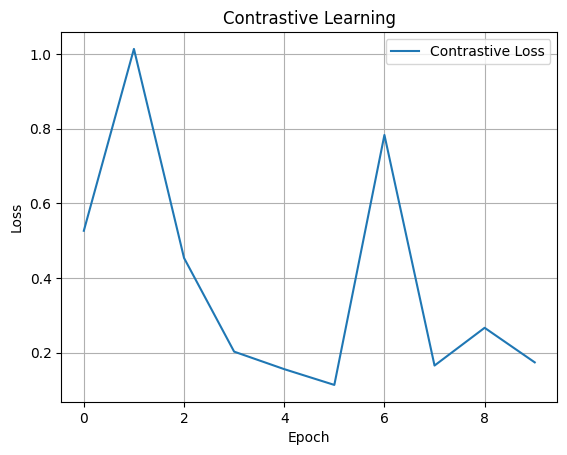

INFO:tensorflow:Assets written to: /tmp/tmphzwcb2de/assets


INFO:tensorflow:Assets written to: /tmp/tmphzwcb2de/assets
2025-08-18 13:08:49.904997: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-18 13:08:49.905053: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-18 13:08:49.905269: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphzwcb2de
2025-08-18 13:08:49.911769: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-18 13:08:49.911793: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmphzwcb2de
2025-08-18 13:08:49.938744: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-18 13:08:49.994281: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmphzwcb2de
2025-08-18 13:08:50.038523: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

Saved TFLite (float): lstm_encoder_contrastive.tflite
INFO:tensorflow:Assets written to: /tmp/tmplu3k7xij/assets


INFO:tensorflow:Assets written to: /tmp/tmplu3k7xij/assets
/opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-08-18 13:08:55.686453: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-18 13:08:55.686531: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-18 13:08:55.686772: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplu3k7xij
2025-08-18 13:08:55.696089: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-18 13:08:55.696130: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmplu3k7xij
2025-08-18 13:08:55.727887: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-18 13:08:55.7

Saved TFLite (int8): lstm_encoder_contrastive_int8.tflite
[OPS] lstm_encoder_contrastive.tflite -> ['ADD', 'FILL', 'FULLY_CONNECTED', 'LOGISTIC', 'MUL', 'PACK', 'SHAPE', 'SPLIT', 'STRIDED_SLICE', 'TANH', 'TRANSPOSE', 'UNPACK']
[OPS] lstm_encoder_contrastive_int8.tflite -> ['ADD', 'FILL', 'FULLY_CONNECTED', 'LOGISTIC', 'MUL', 'PACK', 'SHAPE', 'SPLIT', 'STRIDED_SLICE', 'TANH', 'TRANSPOSE', 'UNPACK']
[OPS] meta_lstm_classifier.tflite -> ['DELEGATE', 'FILL', 'FULLY_CONNECTED', 'FlexTensorListReserve', 'FlexTensorListStack', 'PACK', 'SHAPE', 'SOFTMAX', 'STRIDED_SLICE', 'TRANSPOSE', 'WHILE']


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 2 nodes delegated out of 13 nodes with 2 partitions.



In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import random
import matplotlib.pyplot as plt

# =============================
# 超参数
# =============================
DATA_GLOB = "./data/*.csv"
SEQ_LEN = 64
FEATURE_DIM = 64
BATCH_SIZE = 32
EPOCHS_CONTRASTIVE = 10
EPOCHS_META = 20
INNER_LR = 1e-2
META_LR = 1e-3
NUM_CLASSES = 3
NUM_TASKS = 5
SUPPORT_SIZE = 10
QUERY_SIZE = 20
REPLAY_CAPACITY = 1000
REPLAY_WEIGHT = 0.3
LAMBDA_EWC = 1e-3
FLOWERING_WEIGHT = 2.0  # 花期梯度放大倍數

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# =============================
# 1) 加载 CSV -> 滑窗样本
# =============================
X_labeled_list, y_labeled_list = [], []
X_unlabeled_list = []

for file in sorted(glob.glob(DATA_GLOB)):
    df = pd.read_csv(file).fillna(-1)
    data = df.values.astype(np.float32)
    feats, labels = data[:, :-1], data[:, -1]
    for i in range(len(data) - SEQ_LEN + 1):
        w_x = feats[i:i + SEQ_LEN]
        w_y = labels[i + SEQ_LEN - 1]
        if w_y == -1:
            X_unlabeled_list.append(w_x)
        else:
            X_labeled_list.append(w_x)
            y_labeled_list.append(int(w_y))

X_unlabeled = np.array(X_unlabeled_list, dtype=np.float32) if len(X_unlabeled_list) > 0 else np.empty((0,), dtype=np.float32)
if len(X_labeled_list) > 0:
    X_labeled = np.array(X_labeled_list, dtype=np.float32)
    y_labeled = np.array(y_labeled_list, dtype=np.int32)
else:
    X_labeled = np.empty((0, SEQ_LEN, X_unlabeled.shape[2] if X_unlabeled.size > 0 else 3), dtype=np.float32)
    y_labeled = np.empty((0,), dtype=np.int32)

NUM_FEATS = X_labeled.shape[2] if X_labeled.size > 0 else (X_unlabeled.shape[2] if X_unlabeled.size > 0 else 3)

# =============================
# 2) 对比学习
# =============================
def augment_window(x):
    return x + np.random.normal(0, 0.01, x.shape).astype(np.float32)

def make_contrastive_pairs(X):
    anchors, positives = [], []
    for w in X:
        anchors.append(w)
        positives.append(augment_window(w))
    return np.stack(anchors).astype(np.float32), np.stack(positives).astype(np.float32)

class NTXentLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
    def call(self, z_i, z_j):
        z_i = tf.math.l2_normalize(z_i, axis=1)
        z_j = tf.math.l2_normalize(z_j, axis=1)
        logits = tf.matmul(z_i, z_j, transpose_b=True) / self.temperature
        labels = tf.range(tf.shape(z_i)[0])
        loss_i = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_j = tf.keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(logits), from_logits=True)
        return tf.reduce_mean(loss_i + loss_j)

# *** CHANGED: unroll=True 避免 TensorList ***
def build_lstm_encoder(seq_len, num_feats, feature_dim=FEATURE_DIM):
    inp = layers.Input(shape=(seq_len, num_feats))
    x = layers.LSTM(feature_dim, unroll=True, return_sequences=False)(inp)  # 關鍵
    out = layers.Dense(feature_dim, activation="relu")(x)
    return models.Model(inp, out, name="lstm_encoder")

lstm_encoder = build_lstm_encoder(SEQ_LEN, NUM_FEATS, FEATURE_DIM)
contrastive_opt = tf.keras.optimizers.Adam()
ntxent = NTXentLoss(temperature=0.2)

if X_unlabeled.size == 0:
    # 沒有未標註資料就造一些用於對比學習與量化代表集
    X_unlabeled = np.random.randn(200, SEQ_LEN, NUM_FEATS).astype(np.float32)

anchors, positives = make_contrastive_pairs(X_unlabeled)
contrast_ds = tf.data.Dataset.from_tensor_slices((anchors, positives)).shuffle(2048).batch(BATCH_SIZE)

contrastive_loss_history = []
for ep in range(EPOCHS_CONTRASTIVE):
    for a, p in contrast_ds:
        with tf.GradientTape() as tape:
            za = lstm_encoder(a, training=True)
            zp = lstm_encoder(p, training=True)
            loss = ntxent(za, zp)
        grads = tape.gradient(loss, lstm_encoder.trainable_variables)
        contrastive_opt.apply_gradients(zip(grads, lstm_encoder.trainable_variables))
    contrastive_loss_history.append(float(loss.numpy()))
    print(f"[Contrastive] Epoch {ep+1}/{EPOCHS_CONTRASTIVE}, loss={float(loss.numpy()):.4f}")

# =============================
# 3) FOMAML + LLL + EWC + 花期梯度加權
# =============================
def build_meta_model(encoder, num_classes=NUM_CLASSES):
    inp = layers.Input(shape=(SEQ_LEN, NUM_FEATS))
    x = encoder(inp)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="meta_lstm_classifier")

meta_model = build_meta_model(lstm_encoder, NUM_CLASSES)
meta_optimizer = tf.keras.optimizers.Adam(META_LR)

def sample_tasks(X, y, num_tasks=NUM_TASKS, support_size=SUPPORT_SIZE, query_size=QUERY_SIZE):
    tasks = []
    n = len(X)
    if n < support_size + query_size:
        raise ValueError(f"样本不足以构建任务：需要 {support_size+query_size}，但只有 {n}")
    for _ in range(num_tasks):
        idx = np.random.choice(n, support_size + query_size, replace=False)
        X_support, y_support = X[idx[:support_size]], y[idx[:support_size]]
        X_query, y_query = X[idx[support_size:]], y[idx[support_size:]]
        tasks.append((X_support, y_support, X_query, y_query))
    return tasks

def inner_update(model, X_support, y_support, lr_inner=INNER_LR):
    with tf.GradientTape() as tape:
        preds_support = model(X_support, training=True)
        loss_support = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_support, preds_support))
    grads_inner = tape.gradient(loss_support, model.trainable_variables)
    updated_vars = [w - lr_inner * g for w, g in zip(model.trainable_variables, grads_inner)]
    return updated_vars

class ReplayBuffer:
    def __init__(self, capacity=REPLAY_CAPACITY):
        self.buffer = []
        self.capacity = capacity
        self.n_seen = 0
    def add(self, X, y):
        for xi, yi in zip(X, y):
            self.n_seen += 1
            if len(self.buffer) < self.capacity:
                self.buffer.append((xi, yi))
            else:
                r = np.random.randint(0, self.n_seen)
                if r < self.capacity:
                    self.buffer[r] = (xi, yi)
    def __len__(self):
        return len(self.buffer)
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self.buffer))
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        X_s, y_s = zip(*[self.buffer[i] for i in idxs])
        return np.array(X_s), np.array(y_s)

memory = ReplayBuffer(capacity=REPLAY_CAPACITY)

def outer_update_with_lll(meta_model, meta_optimizer, tasks,
                          lr_inner=INNER_LR, replay_weight=REPLAY_WEIGHT,
                          lambda_ewc=LAMBDA_EWC, prev_weights=None):
    meta_grads = [tf.zeros_like(v) for v in meta_model.trainable_variables]
    query_acc_list, query_loss_list = [], []

    for X_support, y_support, X_query, y_query in tasks:
        orig_vars = [tf.identity(v) for v in meta_model.trainable_variables]

        # inner update
        updated_vars = inner_update(meta_model, X_support, y_support)
        for var, upd in zip(meta_model.trainable_variables, updated_vars):
            var.assign(upd)

        with tf.GradientTape() as tape:
            preds_q = meta_model(X_query, training=True)
            loss_q = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_query, preds_q))
            loss_total = loss_q

            # replay
            if len(memory) >= 8:
                X_old, y_old = memory.sample(batch_size=32)
                preds_old = meta_model(X_old, training=True)
                replay_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_old, preds_old))
                loss_total = (1 - replay_weight) * loss_total + replay_weight * replay_loss

            # EWC（近似）
            if prev_weights is not None:
                ewc_loss = 0.0
                for w, pw in zip(meta_model.trainable_variables, prev_weights):
                    ewc_loss += tf.reduce_sum(tf.square(w - pw))
                loss_total += lambda_ewc * ewc_loss

        grads = tape.gradient(loss_total, meta_model.trainable_variables)

        # ===== 花期梯度加權 =====
        flowering_idx = []
        for i in range(len(X_query)):
            x_seq = X_query[i]
            light_total = x_seq[:, 0:3].sum()  # 假設前3個feat為 light
            if light_total > 850:
                flowering_idx.append(i)
        if flowering_idx:
            for i, g in enumerate(grads):
                grads[i] = g * (1 + (FLOWERING_WEIGHT - 1) * len(flowering_idx) / len(X_query))

        meta_grads = [mg + g / len(tasks) for mg, g in zip(meta_grads, grads)]

        q_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds_q, axis=1), y_query), tf.float32))
        query_acc_list.append(float(q_acc.numpy()))
        query_loss_list.append(float(loss_q.numpy()))

        for var, orig in zip(meta_model.trainable_variables, orig_vars):
            var.assign(orig)

        memory.add(X_support, y_support)
        memory.add(X_query, y_query)

    meta_optimizer.apply_gradients(zip(meta_grads, meta_model.trainable_variables))
    return float(np.mean(query_loss_list)), float(np.mean(query_acc_list)), [tf.identity(v) for v in meta_model.trainable_variables]

# ======= 训练元学习 =======
meta_loss_history, meta_acc_history = [], []
prev_weights = None

if X_labeled.size > 0:
    for ep in range(EPOCHS_META):
        tasks = sample_tasks(X_labeled, y_labeled)
        loss, acc, prev_weights = outer_update_with_lll(meta_model, meta_optimizer, tasks, prev_weights=prev_weights)
        meta_loss_history.append(loss)
        meta_acc_history.append(acc)
        print(f"[Meta] Epoch {ep+1}/{EPOCHS_META}, loss={loss:.4f}, acc={acc:.4f}")
else:
    print("跳过元学习：没有有标签数据。")

# =============================
# 4) 可视化
# =============================
plt.figure()
plt.plot(contrastive_loss_history, label="Contrastive Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Contrastive Learning")
plt.legend(); plt.grid(True); plt.show()

if meta_loss_history:
    plt.figure()
    plt.plot(meta_loss_history, label="Query Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("FOMAML + LLL + EWC Loss")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure()
    plt.plot(meta_acc_history, label="Query Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("FOMAML + LLL + EWC Accuracy")
    plt.legend(); plt.grid(True); plt.show()

# =============================
# 5) TFLite 导出（MCU 友好）
# =============================

# *** CHANGED: 僅允許內建算子，避免 Flex ***
def save_tflite_float(model, out_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]  # 關鍵
    # 如需縮小模型亦可開啟 float16（MCU 以 FP32/FP16 跑，無 Flex）
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # converter.target_spec.supported_types = [tf.float16]
    tflite_model = converter.convert()
    with open(out_path, "wb") as f:
        f.write(tflite_model)
    print("Saved TFLite (float):", out_path)

# 可選：整數 int8 量化（若 LSTM 展開為基礎算子通常可行；若不支持會回退）
def save_tflite_int8(model, out_path, rep_data):
    try:
        def rep_dataset():
            # 使用未標註窗口作代表集（取最多 200 個樣本加速）
            n = min(len(rep_data), 200)
            for i in range(n):
                x = rep_data[i:i+1].astype(np.float32)
                yield [x]

        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = rep_dataset
        # 全整數量化（若不支持，可能報錯）
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8
        tflite_model = converter.convert()
        with open(out_path, "wb") as f:
            f.write(tflite_model)
        print("Saved TFLite (int8):", out_path)
    except Exception as e:
        print("[Int8] 量化不支持或失敗，回退到 float32。原因：", e)
        save_tflite_float(model, out_path.replace(".tflite", "_float.tflite"))

# 導出 Encoder 與 Meta 模型
save_tflite_float(lstm_encoder, "lstm_encoder_contrastive.tflite")
if X_unlabeled.size > 0:
    save_tflite_int8(lstm_encoder, "lstm_encoder_contrastive_int8.tflite", X_unlabeled)

if X_labeled.size > 0:
    save_tflite_float(meta_model, "meta_lstm_classifier.tflite")
    if X_unlabeled.size > 0:
        save_tflite_int8(meta_model, "meta_lstm_classifier_int8.tflite", X_unlabeled)

# 簡單驗證：嘗試載入 TFLite 並列出算子（檢查是否出現 Flex）
def check_tflite_ops(path):
    try:
        interp = tf.lite.Interpreter(model_path=path)
        interp.allocate_tensors()
        ops = interp._get_ops_details()
        op_names = sorted(set([op['op_name'] for op in ops]))
        print(f"[OPS] {os.path.basename(path)} ->", op_names)
    except Exception as e:
        print(f"[OPS] 無法載入 {path}：", e)

for p in ["lstm_encoder_contrastive.tflite",
          "lstm_encoder_contrastive_int8.tflite",
          "meta_lstm_classifier.tflite",
          "meta_lstm_classifier_int8.tflite",
          "meta_lstm_classifier_float.tflite"]:
    if os.path.exists(p):
        check_tflite_ops(p)


[Contrastive] Epoch 1/10, loss=0.4867
[Contrastive] Epoch 2/10, loss=0.5248
[Contrastive] Epoch 3/10, loss=0.2792
[Contrastive] Epoch 4/10, loss=0.2793
[Contrastive] Epoch 5/10, loss=0.2837
[Contrastive] Epoch 6/10, loss=0.1264
[Contrastive] Epoch 7/10, loss=0.7225
[Contrastive] Epoch 8/10, loss=0.1968
[Contrastive] Epoch 9/10, loss=0.2291
[Contrastive] Epoch 10/10, loss=0.1127
Skip meta-learning: no labeled data.
INFO:tensorflow:Assets written to: /tmp/tmpfwv2v_y8/assets


INFO:tensorflow:Assets written to: /tmp/tmpfwv2v_y8/assets
2025-08-18 13:58:52.730118: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-18 13:58:52.730236: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-18 13:58:52.730710: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfwv2v_y8
2025-08-18 13:58:52.738617: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-18 13:58:52.738660: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpfwv2v_y8
2025-08-18 13:58:52.790417: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-18 13:58:52.855486: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpfwv2v_y8
2025-08-18 13:58:52.908206: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

Saved TFLite: lstm_encoder_contrastive.tflite
Done.


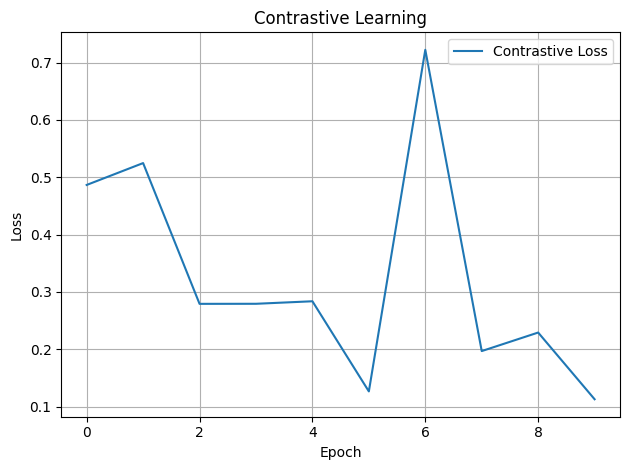

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Meta-learning pipeline with HVAC-aware features and flowering-period focus.
- Expects CSV columns: temp, humid, light, ac, heater, dehum, hum, label
- Sliding windows -> contrastive learning (unlabeled) + FOMAML with LLL + EWC (labeled)
- Encoder: LSTM on continuous features only (temp/humid/light)
- Additional HVAC features: mean on/off rate + toggle rate (abs(diff)) over time
- Gradient boost on flowering period with abnormal HVAC toggling
- TFLite export restricted to TFLITE_BUILTINS
"""

import os, glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import random
import matplotlib.pyplot as plt

# =============================
# Hyperparameters
# =============================
DATA_GLOB = "./data/*.csv"
SEQ_LEN = 64
FEATURE_DIM = 64
BATCH_SIZE = 32
EPOCHS_CONTRASTIVE = 10
EPOCHS_META = 20
INNER_LR = 1e-2
META_LR = 1e-3
NUM_CLASSES = 3
NUM_TASKS = 5
SUPPORT_SIZE = 10
QUERY_SIZE = 20
REPLAY_CAPACITY = 1000
REPLAY_WEIGHT = 0.3
LAMBDA_EWC = 1e-3
FLOWERING_WEIGHT = 2.0  # gradient boost upper bound for flowering-focus

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# =============================
# 1) Load CSV -> Sliding windows
# =============================
X_labeled_list, y_labeled_list = [], []
X_unlabeled_list = []

for file in sorted(glob.glob(DATA_GLOB)):
    df = pd.read_csv(file).fillna(-1)
    data = df.values.astype(np.float32)
    feats, labels = data[:, :-1], data[:, -1]
    for i in range(len(data) - SEQ_LEN + 1):
        w_x = feats[i:i + SEQ_LEN]
        w_y = labels[i + SEQ_LEN - 1]
        if w_y == -1:
            X_unlabeled_list.append(w_x)
        else:
            X_labeled_list.append(w_x)
            y_labeled_list.append(int(w_y))

X_unlabeled = np.array(X_unlabeled_list, dtype=np.float32) if len(X_unlabeled_list) > 0 else np.empty((0,), dtype=np.float32)
if len(X_labeled_list) > 0:
    X_labeled = np.array(X_labeled_list, dtype=np.float32)
    y_labeled = np.array(y_labeled_list, dtype=np.int32)
else:
    # fallback shape (not ideal; expect at least unlabeled data present)
    X_labeled = np.empty((0, SEQ_LEN, X_unlabeled.shape[2] if X_unlabeled.size > 0 else 7), dtype=np.float32)
    y_labeled = np.empty((0,), dtype=np.int32)

NUM_FEATS = X_labeled.shape[2] if X_labeled.size > 0 else (X_unlabeled.shape[2] if X_unlabeled.size > 0 else 7)

# Verify hvac columns exist
if NUM_FEATS < 7:
    raise ValueError("Expected at least 7 features per timestep: [temp, humid, light, ac, heater, dehum, hum]. Found: %d" % NUM_FEATS)

# Index conventions
CONT_IDX = [0, 1, 2]   # temp, humid, light
HVAC_IDX = [3, 4, 5, 6]  # ac, heater, dehum, hum

# =============================
# 2) Contrastive learning
# =============================
def augment_window(x):
    """Only perturb continuous channels to keep binary HVAC channels intact."""
    x_aug = x.copy()
    x_aug[:, CONT_IDX] = x[:, CONT_IDX] + np.random.normal(0, 0.01, x[:, CONT_IDX].shape).astype(np.float32)
    return x_aug

def make_contrastive_pairs(X):
    anchors, positives = [], []
    for w in X:
        anchors.append(w)
        positives.append(augment_window(w))
    return np.stack(anchors).astype(np.float32), np.stack(positives).astype(np.float32)

class NTXentLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.2):
        super().__init__()
        self.temperature = temperature
    def call(self, z_i, z_j):
        z_i = tf.math.l2_normalize(z_i, axis=1)
        z_j = tf.math.l2_normalize(z_j, axis=1)
        logits = tf.matmul(z_i, z_j, transpose_b=True) / self.temperature
        labels = tf.range(tf.shape(z_i)[0])
        loss_i = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_j = tf.keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(logits), from_logits=True)
        return tf.reduce_mean(loss_i + loss_j)

# =============================
# 2) LSTM Encoder (unroll=True, continuous only)
# =============================
def build_lstm_encoder(seq_len, num_feats, feature_dim=FEATURE_DIM):
    inp = layers.Input(shape=(seq_len, num_feats))
    x_cont = layers.Lambda(lambda z: z[:, :, :3])(inp)  # [B,T,3]
    x = layers.LSTM(feature_dim, unroll=True)(x_cont)
    out = layers.Dense(feature_dim, activation="relu")(x)
    return models.Model(inp, out, name="lstm_encoder")

# =============================
# 3) Meta Model (Encoder + HVAC features)
# =============================
def build_meta_model(encoder, num_classes=NUM_CLASSES):
    inp = layers.Input(shape=(SEQ_LEN, NUM_FEATS))   # expect >=7
    z_enc = encoder(inp)  # [B, FEATURE_DIM]

    # HVAC slice
    hvac = layers.Lambda(lambda z: z[:, :, 3:7])(inp)   # [B,T,4]
    hvac_mean = layers.Lambda(lambda z: tf.reduce_mean(z, axis=1))(hvac)  # [B,4]

    # Toggle rate via abs(diff)
    hvac_shift = layers.Lambda(lambda z: z[:, 1:, :])(hvac)      # [B,T-1,4]
    hvac_prev  = layers.Lambda(lambda z: z[:, :-1, :])(hvac)     # [B,T-1,4]
    hvac_diff  = layers.Lambda(lambda t: tf.abs(t[0] - t[1]))([hvac_shift, hvac_prev])  # [B,T-1,4]
    hvac_toggle_rate = layers.Lambda(lambda z: tf.reduce_mean(z, axis=1))(hvac_diff)    # [B,4]

    hvac_feat = layers.Concatenate()([hvac_mean, hvac_toggle_rate])  # [B,8]
    hvac_feat = layers.Dense(16, activation="relu")(hvac_feat)

    x = layers.Concatenate()([z_enc, hvac_feat])
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return models.Model(inp, out, name="meta_lstm_classifier")

# Build models
lstm_encoder = build_lstm_encoder(SEQ_LEN, NUM_FEATS, FEATURE_DIM)
contrastive_opt = tf.keras.optimizers.Adam()
ntxent = NTXentLoss(temperature=0.2)

# Provide unlabeled fallback if none
if X_unlabeled.size == 0:
    X_unlabeled = np.random.randn(200, SEQ_LEN, NUM_FEATS).astype(np.float32)

anchors, positives = make_contrastive_pairs(X_unlabeled)
contrast_ds = tf.data.Dataset.from_tensor_slices((anchors, positives)).shuffle(2048).batch(BATCH_SIZE)

# Train contrastive
contrastive_loss_history = []
for ep in range(EPOCHS_CONTRASTIVE):
    for a, p in contrast_ds:
        with tf.GradientTape() as tape:
            za = lstm_encoder(a, training=True)
            zp = lstm_encoder(p, training=True)
            loss = ntxent(za, zp)
        grads = tape.gradient(loss, lstm_encoder.trainable_variables)
        contrastive_opt.apply_gradients(zip(grads, lstm_encoder.trainable_variables))
    contrastive_loss_history.append(float(loss.numpy()))
    print(f"[Contrastive] Epoch {ep+1}/{EPOCHS_CONTRASTIVE}, loss={float(loss.numpy()):.4f}")

# Meta model
meta_model = build_meta_model(lstm_encoder, NUM_CLASSES)
meta_optimizer = tf.keras.optimizers.Adam(META_LR)

def sample_tasks(X, y, num_tasks=NUM_TASKS, support_size=SUPPORT_SIZE, query_size=QUERY_SIZE):
    tasks = []
    n = len(X)
    if n < support_size + query_size:
        raise ValueError(f"Not enough labeled samples to build tasks: need {support_size+query_size}, got {n}")
    for _ in range(num_tasks):
        idx = np.random.choice(n, support_size + query_size, replace=False)
        X_support, y_support = X[idx[:support_size]], y[idx[:support_size]]
        X_query, y_query = X[idx[support_size:]], y[idx[support_size:]]
        tasks.append((X_support, y_support, X_query, y_query))
    return tasks

def inner_update(model, X_support, y_support, lr_inner=INNER_LR):
    with tf.GradientTape() as tape:
        preds_support = model(X_support, training=True)
        loss_support = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_support, preds_support))
    grads_inner = tape.gradient(loss_support, model.trainable_variables)
    updated_vars = [w - lr_inner * g for w, g in zip(model.trainable_variables, grads_inner)]
    return updated_vars

class ReplayBuffer:
    def __init__(self, capacity=REPLAY_CAPACITY):
        self.buffer = []
        self.capacity = capacity
        self.n_seen = 0
    def add(self, X, y):
        for xi, yi in zip(X, y):
            self.n_seen += 1
            if len(self.buffer) < self.capacity:
                self.buffer.append((xi, yi))
            else:
                r = np.random.randint(0, self.n_seen)
                if r < self.capacity:
                    self.buffer[r] = (xi, yi)
    def __len__(self):
        return len(self.buffer)
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self.buffer))
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        X_s, y_s = zip(*[self.buffer[i] for i in idxs])
        return np.array(X_s), np.array(y_s)

memory = ReplayBuffer(capacity=REPLAY_CAPACITY)

# ===== Helpers for flowering focus =====
def is_flowering_seq(x_seq, light_idx=2, th_light=550.0):
    light_mean = float(np.mean(x_seq[:, light_idx]))
    return light_mean >= th_light

def hvac_toggle_score(x_seq, hvac_slice=slice(3,7), th_toggle=0.15):
    hv = x_seq[:, hvac_slice]  # [T,4]
    if hv.shape[0] < 2:
        return 0.0, False
    diff = np.abs(hv[1:] - hv[:-1])   # [T-1,4]
    rate = float(diff.mean())
    return rate, rate >= th_toggle

def outer_update_with_lll(meta_model, meta_optimizer, tasks,
                          lr_inner=INNER_LR, replay_weight=REPLAY_WEIGHT,
                          lambda_ewc=LAMBDA_EWC, prev_weights=None):
    meta_grads = [tf.zeros_like(v) for v in meta_model.trainable_variables]
    query_acc_list, query_loss_list = [], []

    for X_support, y_support, X_query, y_query in tasks:
        orig_vars = [tf.identity(v) for v in meta_model.trainable_variables]

        # inner update
        updated_vars = inner_update(meta_model, X_support, y_support)
        for var, upd in zip(meta_model.trainable_variables, updated_vars):
            var.assign(upd)

        with tf.GradientTape() as tape:
            preds_q = meta_model(X_query, training=True)
            loss_q = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_query, preds_q))
            loss_total = loss_q

            # replay
            if len(memory) >= 8:
                X_old, y_old = memory.sample(batch_size=32)
                preds_old = meta_model(X_old, training=True)
                replay_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_old, preds_old))
                loss_total = (1 - replay_weight) * loss_total + replay_weight * replay_loss

            # EWC (L2 to prev weights as proxy)
            if prev_weights is not None:
                ewc_loss = 0.0
                for w, pw in zip(meta_model.trainable_variables, prev_weights):
                    ewc_loss += tf.reduce_sum(tf.square(w - pw))
                loss_total += lambda_ewc * ewc_loss

        grads = tape.gradient(loss_total, meta_model.trainable_variables)

        # ===== Flowering + HVAC toggling gradient boost =====
        flowering_mask = []
        toggle_scores = []
        for i in range(len(X_query)):
            x_seq = X_query[i]  # [T,D]
            flw = is_flowering_seq(x_seq, light_idx=2, th_light=550.0)
            tscore, tabove = hvac_toggle_score(x_seq, hvac_slice=slice(3,7), th_toggle=0.15)
            flowering_mask.append(bool(flw and tabove))
            toggle_scores.append(tscore)

        if any(flowering_mask):
            ratio = sum(flowering_mask) / len(flowering_mask)
            mean_toggle = np.mean([t for m,t in zip(flowering_mask, toggle_scores) if m]) if any(flowering_mask) else 0.0
            toggle_boost = min(1.0 + float(mean_toggle)*2.0, FLOWERING_WEIGHT)
            boost = 1.0 + (FLOWERING_WEIGHT - 1.0) * ratio
            total_boost = float(min(boost * toggle_boost, FLOWERING_WEIGHT))
            grads = [g * total_boost for g in grads]

        meta_grads = [mg + g / len(tasks) for mg, g in zip(meta_grads, grads)]

        q_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds_q, axis=1), y_query), tf.float32))
        query_acc_list.append(float(q_acc.numpy()))
        query_loss_list.append(float(loss_q.numpy()))

        # restore original vars
        for var, orig in zip(meta_model.trainable_variables, orig_vars):
            var.assign(orig)

        # update memory
        memory.add(X_support, y_support)
        memory.add(X_query, y_query)

    meta_optimizer.apply_gradients(zip(meta_grads, meta_model.trainable_variables))
    return float(np.mean(query_loss_list)), float(np.mean(query_acc_list)), [tf.identity(v) for v in meta_model.trainable_variables]

# ======= Train meta-learning =======
meta_loss_history, meta_acc_history = [], []
prev_weights = None

if X_labeled.size > 0:
    for ep in range(EPOCHS_META):
        tasks = sample_tasks(X_labeled, y_labeled)
        loss, acc, prev_weights = outer_update_with_lll(meta_model, meta_optimizer, tasks, prev_weights=prev_weights)
        meta_loss_history.append(loss)
        meta_acc_history.append(acc)
        print(f"[Meta] Epoch {ep+1}/{EPOCHS_META}, loss={loss:.4f}, acc={acc:.4f}")
else:
    print("Skip meta-learning: no labeled data.")

# =============================
# 4) Visualization
# =============================
plt.figure()
plt.plot(contrastive_loss_history, label="Contrastive Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Contrastive Learning")
plt.legend(); plt.grid(True); plt.tight_layout()

if meta_loss_history:
    plt.figure()
    plt.plot(meta_loss_history, label="Query Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("FOMAML + LLL + EWC Loss")
    plt.legend(); plt.grid(True); plt.tight_layout()

    plt.figure()
    plt.plot(meta_acc_history, label="Query Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("FOMAML + LLL + EWC Accuracy")
    plt.legend(); plt.grid(True); plt.tight_layout()

# =============================
# 5) TFLite export (BUILTINS only)
# =============================
def save_tflite(model, out_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    tflite_model = converter.convert()
    with open(out_path, "wb") as f:
        f.write(tflite_model)
    print("Saved TFLite:", out_path)

# Save models
save_tflite(lstm_encoder, "lstm_encoder_contrastive.tflite")
if X_labeled.size > 0:
    save_tflite(meta_model, "meta_lstm_classifier.tflite")

print("Done.")
